## Workshop 4: Supply Chain Case Study Practise

This notebook illustrates Example 20 from Chapter 3 of the textbook Hands-On Mathematical Optimization with Python, Cambridge University Press, 2024.

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [6]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
import platform
import os 

# Solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe", "solver/cbc.exe", "solver/ampl.mswin64/bonmin.exe"
    elif os_name == "Linux":
        os.system("chmod +x solver/ipopt")
        os.system("chmod +x solver/cbc")
        os.system("chmod +x solver/bonmin")
        return "solver/ipopt", "solver/cbc", "solver/bonmin"

ipopt_executable, cbc_executable, bonmin_executable = setup_solver()

### 2. Problem description

A supplier wishes to fulfill specific customer demands with minimal costs while simultaneously deciding how many facilities to build and where. In terms of data, we are given a set $I$ of customers, a set $J$ of possible locations, the cost $c_j$ of building facility $j$, and the cost $h_{ij}$ incurred to satisfy the demands of customer $i$ at facility $j$.


#### a. MILP Formulation


\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \text{s.t.} \quad & \sum_{j \in J} y_{ij} = 1 \qquad \forall \, i \in I & \text{(every customer is served)} \\
    & y_{ij} \leq x_{j} \quad \: \qquad \forall \, i\in I, \, \forall \, j \in J & \text{(facility built before use)} \\
    & x_j \in \{0,1\} \qquad \forall \, j \in J \\
    & y_{ij} \in \{0,1\} \qquad \forall \, i \in I, \, \forall \, j \in J.
\end{align*}



$$
x_j := 
\begin{cases}
    1 & \text{if facility $j$ is built,} \\
    0 & \text{otherwise,} \\
\end{cases}
$$

$$
y_{ij} := 
\begin{cases}
    1 & \text{if customer $i$ is served at facility $j$,} \\
    0 & \text{otherwise.} \\
\end{cases}
$$

$$
h_{ij} \propto d_{ij} \quad \text{where} \: d_{ij} = \text{Euclidean distance from customer} \: i \: \text{to facility} \: j.
$$

#### a. Function to Random Generate Customer Locations

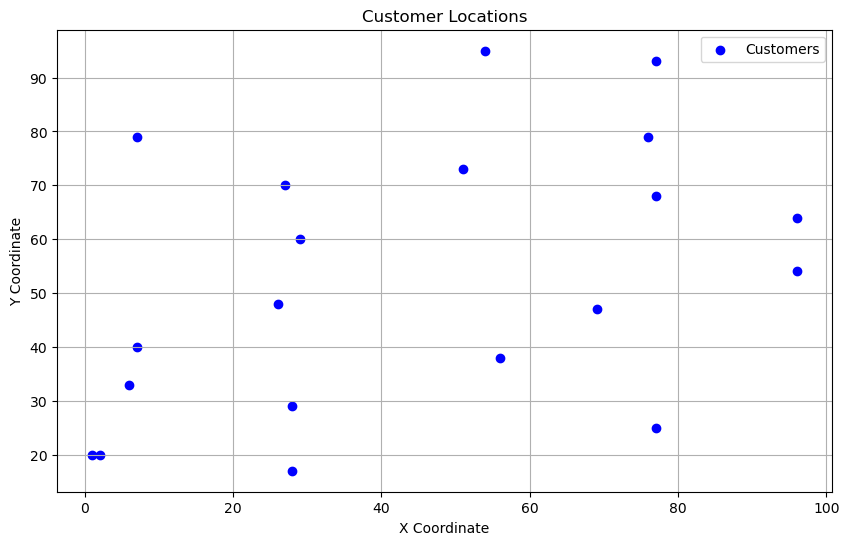

In [7]:
# Set the random seed for reproducibility
np.random.seed(2026)

# Function to generate random customer locations
def GenerateCustomerLocations(num_customers):
    xC = np.random.randint(0, 100, num_customers)   # Customer x-coordinates
    yC = np.random.randint(0, 100, num_customers)   # Customer y-coordinates
    return xC, yC

# Generate customer locations
num_customers = 20
xC, yC = GenerateCustomerLocations(num_customers)

# Visualize customer locations
plt.figure(figsize=(10, 6))
plt.scatter(xC, yC, marker='o', label='Customers', color='blue')  # Plot customers
plt.title("Customer Locations")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid()
plt.legend()
plt.show()

#### b. Add your own facility locations here! Visualise customers and facilities

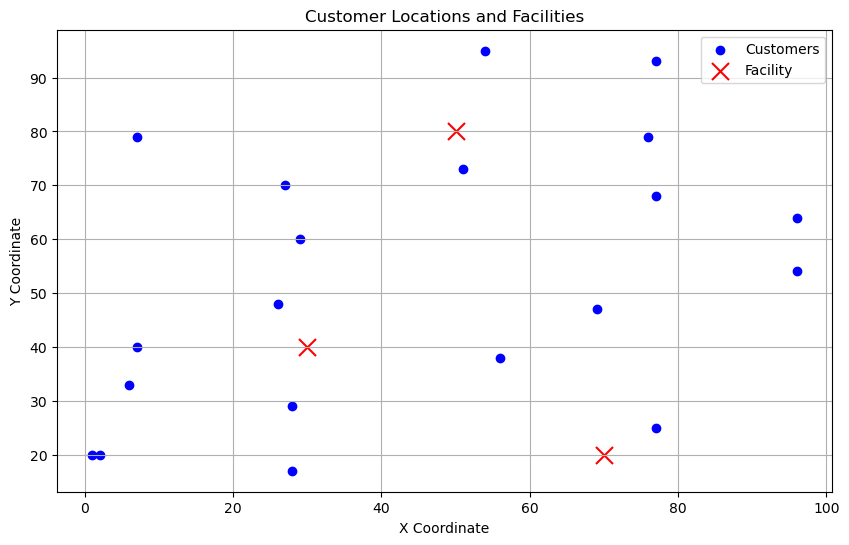

In [8]:
# Initialize facility locations array
facility_locations = []

# Example: Adding facility locations manually
# You can modify this array directly to add your facility locations
facility_locations.append((30, 40))  # Example facility 1
facility_locations.append((70, 20))  # Example facility 2
facility_locations.append((50, 80))  # Example facility 3

# Convert facility locations to coordinates
xF = np.array([loc[0] for loc in facility_locations])
yF = np.array([loc[1] for loc in facility_locations])

# Visualize both customers and facilities
plt.figure(figsize=(10, 6))
plt.scatter(xC, yC, marker='o', label='Customers', color='blue')  # Plot customers
for loc in facility_locations:
    plt.scatter(loc[0], loc[1], color='red', marker='x', s=150, label='Facility' if loc == facility_locations[0] else "")  # Plot facilities

plt.title("Customer Locations and Facilities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid()
plt.legend()
plt.show()

#### c. Facility-Customer Optimisation Problem

In [9]:
def CreateFacilityLocationModel(installation, service):
    model = ConcreteModel()
    
    # Sets for facilities and customers
    model.facilities = Set(initialize=range(len(installation)))  # Facility indices
    model.customers = Set(initialize=range(len(service)))        # Customer indices

    # Decision variables: binary for facility and customer-service relationships
    model.x = Var(model.facilities, within=Binary)                   # 1 if facility j is built
    model.y = Var(model.customers, model.facilities, within=Binary)  # 1 if customer i is served by facility j

    # Objective: minimize total costs of facilities and service
    @model.Objective(sense=minimize)
    def obj(model):
        return (sum(installation[j] * model.x[j] for j in model.facilities) +                          # Facility costs
                sum(service[i][j] * model.y[i, j] for i in model.customers for j in model.facilities)) # Serving costs

    # Constraint: each customer must be served by exactly one facility
    @model.Constraint(model.customers)
    def ChooseOneFacility(model, i):
        return sum(model.y[i, j] for j in model.facilities) == 1

    # Constraint: if customer i is served by facility j, facility j must be open
    @model.Constraint(model.customers, model.facilities)
    def ServeIfOpen(model, i, j):
        return model.y[i, j] <= model.x[j]

    return model  # Return the complete model

#### d. Solving and Visualising Problem

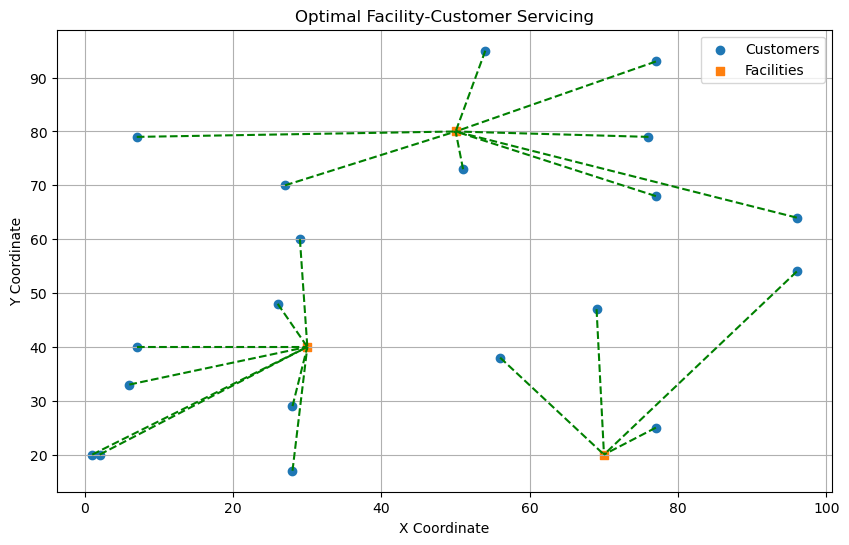

15494.0


In [10]:
# Installation costs for each facility (fixed costs)
installation = [10] * len(facility_locations)  # Example fixed costs

# Calculate service distances based on the selected facility locations
service = [
    [(xC[i] - xF[j])**2 + (yC[i] - yF[j])**2 for j in range(len(facility_locations))]
    for i in range(num_customers)
]

# Create and solve the model
model = CreateFacilityLocationModel(installation, service)
solver = SolverFactory("bonmin", executable = bonmin_executable)  # Replace with your solver of choice
solver.solve(model)

# Extract and display the solution
X = [model.x[j]() > 0.5 for j in range(len(facility_locations))]  # Built facilities
Y = [[model.y[i, j]() > 0.5 for j in range(len(facility_locations))] for i in range(num_customers)]  # Service matrix

# Visualize the solution
def ShowSolution(xC, yC, xF, yF, X, Y, title=None):
    plt.figure(figsize=(10, 6))
    # Draw connections between facilities and customers
    for j in range(len(X)):
        if X[j]:  # If facility j is built
            for i in range(len(Y)):
                if Y[i][j]:  # If customer i is served by facility j
                    plt.plot([xC[i], xF[j]], [yC[i], yF[j]], "g--")

    plt.scatter(xC, yC, marker='o', label='Customers')  # Plot customers
    plt.scatter(xF, yF, marker='s', label='Facilities')  # Plot facilities
    plt.title(title or "Facility-Customer Servicing")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid()
    plt.show()

# Display Optimal Facility-Customer Servicing
ShowSolution(xC, yC, xF, yF, X, Y, title="Optimal Facility-Customer Servicing")

print(model.obj())